<span style="color:blue">

## ■ "네이버 뉴스" site에서 특정 키워드로 검색하는 프로그램 작성
    
</span>

##### 필수 구현 요소
- "특정 검색어" & "마지막 페이지" 입력받기
- 입력된 페이지 수 만큼 기사 헤드라인 검색 및 수집
- 수집한 단어를 출현 빈도에 근거하여 키워드의 word cloud 그리기


In [1]:
## 기본
import numpy as np                    # numpy 패키지 가져오기
import pandas as pd                   # pandas 패키지 가져오기
import matplotlib.pyplot as plt       # 시각화 패키지 가져오기

## Text 데이터 처리
from konlpy.tag import Okt
from konlpy.tag import Kkma
from konlpy.tag import Komoran
from konlpy.tag import Hannanum

from collections import Counter
from wordcloud import WordCloud

from bs4 import BeautifulSoup
import requests

import warnings
warnings.filterwarnings('ignore')


## (1) 해당 사이트 탐색 단계

###  ■ 네이버 검색창에서 '인공지능'  입력 후 뉴스 페이지로 이동 - 해당 url 을 복사해서 url 변수에  insert

<!DOCTYPE doctype html>
 <html lang="ko"> <head> <meta charset="utf-8"/> <meta content="always" name="referrer"/> <meta content="telephone=no,address=no,email=no" name="format-detection"/> <meta content="width=device-width,initial-scale=1.0,maximum-scale=2.0" name="viewport"/> <meta content="인공지능 : 네이버 뉴스검색" property="og:title"> <meta content="https://ssl.pstatic.net/sstatic/search/common/og_v3.png" property="og:image"/> <meta content="'인공지능'의 네이버 뉴스검색 결과입니다." property="og:description"/> <meta content="'인공지능'의 네이버 뉴스검색 결과입니다." lang="ko" name="description"/> <title>인공지능 : 네이버 뉴스검색</title> <link href="https://ssl.pstatic.net/sstatic/search/favicon/favicon_191118_pc.ico" rel="shortcut icon"/> <link href="https://ssl.pstatic.net/sstatic/search/opensearch-description.https.xml" rel="search" title="Naver" type="application/opensearchdescription+xml"><link href="https://ssl.pstatic.net/sstatic/search/pc/css/search1_210422.css" rel="stylesheet" type="text/css"/> <link href="https://ssl.pstatic
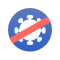
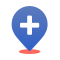
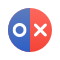
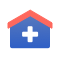

In [15]:

url ='https://search.naver.com/search.naver?where=news&sm=tab_jum&query=%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5&nso=so%3Ar%2Cp%3Aall%2Ca%3Aall'

req = requests.get(url)    # 해당 페이지를 가져옴

page = BeautifulSoup(req.text , 'html.parser')

print(page)


### ▶ 검색 데이터의 headline 을 추출한다.

#### -  F12 (검사 모드) 누른 후 해당 소스의 태그 id 혹은 class 를 찾는다.

In [16]:
titles = page.find_all(attrs='news_tit')

print(titles)

[<a class="news_tit" href="http://www.edaily.co.kr/news/newspath.asp?newsid=02161526629020384" onclick="return goOtherCR(this, 'a=nws*a.tit&amp;r=1&amp;i=880000E7_000000000000000004913108&amp;g=018.0004913108&amp;u='+urlencode(this.href));" target="_blank" title="삼성전자, 인공지능 로봇청소기 '비스포크 제트봇 AI' 출시">삼성전자, <mark>인공지능</mark> 로봇청소기 '비스포크 제트봇 AI' 출시</a>, <a class="news_tit" href="http://www.hani.co.kr/arti/economy/consumer/992773.html" onclick="return goOtherCR(this, 'a=nws*a.tit&amp;r=6&amp;i=88000103_000000000000000002542099&amp;g=028.0002542099&amp;u='+urlencode(this.href));" target="_blank" title="삼성전자, 인공지능 청소기 ‘비스포크 제트 봇 AI’ 출시">삼성전자, <mark>인공지능</mark> 청소기 ‘비스포크 제트 봇 AI’ 출시</a>, <a class="news_tit" href="http://www.newsis.com/view/?id=NISX20210427_0001420869&amp;cID=10802&amp;pID=14000" onclick="return goOtherCR(this, 'a=nws*a.tit&amp;r=11&amp;i=88000127_000000000000000010467974&amp;g=003.0010467974&amp;u='+urlencode(this.href));" target="_blank" title="인천시, 인공지능 덕분에…방역 역할 톡톡">인천시, <ma

### ▶ 검색된 title의 크기를 확인한다.

In [17]:
print(len(titles))

10


### ▶ 검색된 title의 각각을 프린트 한다.

In [18]:
for title in titles :
    print(title.text)
    print()

삼성전자, 인공지능 로봇청소기 '비스포크 제트봇 AI' 출시

삼성전자, 인공지능 청소기 ‘비스포크 제트 봇 AI’ 출시

인천시, 인공지능 덕분에…방역 역할 톡톡

인공지능 투자 파운트, 투자자 10명 중 7명은 적립식 투자

단국대, 학생에게 인공지능 비서 제공

한컴인텔리전스·곰앤컴퍼니, 인공지능 분야 업무협약

호남대학교, 인공지능 신기술 릴레이 특강

아이반, '인공지능' 오디오 티저 공개…"분위기 좋은 노래 틀어줘"

인공지능 사서·드론 배송…30년후 도서관 둘러보세요

단국대, 국내 최초 인공지능 학사지원 시스템 운영



## (2) 본격 스크래핑 단계 


### ▶ 첫 페이지부터 원하는 페이지 까지 뉴스 헤드라인을 스크래핑하는 함수 정의

In [19]:
# 해드라인 검색 및 추출 함수를 정의
# 검색 키워드 & 스타트 페이지 & 검색 마지막 페이지를 parameter(매개변수) 로 받음
# 파이썬은 매개변수가 여러개 인 경우 뒤의 매개 변수부터 디폴트값을 가질 수 있음 


title_list = []

def web_scraping(keyword, end, start = 1):    # 시작 페이지의 default 값은 1 (즉, 첫 페이지 부터 시작) 
    while 1:

        if start > end * 10 :    # 스타트 페이지가 마지막 페이지보다 크면 while 문을 빠져 나감 
            break        
        
        url ='https://search.naver.com/search.naver?where=news&sm=tab_pge&query={}&start={}'.format(keyword,start)

        req = requests.get(url)    # 해당 페이지를 가져옴

        page = BeautifulSoup(req.text, 'html.parser')

        titles = page.find_all(attrs='news_tit')     # 헤드라인 기사를 가져옴 
        
        print(titles)       # 추출한 헤드라인을 확인 (10개)

        for one in titles:
            title_list.append(one.text)
            
        start += 10

        

### ▶ 위 함수를 호출

In [20]:
# 검색어를 입력 받음 
keyword = input('검색어를 입력하세요 : ')
print()

end_page = int(input('스크래핑할 마지막 페이지를 입력하세요 : '))

web_scraping(keyword, end_page)       # 10 페이지 까지 스크래핑을 해온다.


검색어를 입력하세요 : 인공지능

스크래핑할 마지막 페이지를 입력하세요 : 10
[<a class="news_tit" href="http://www.edaily.co.kr/news/newspath.asp?newsid=02161526629020384" onclick="return goOtherCR(this, 'a=nws*a.tit&amp;r=1&amp;i=880000E7_000000000000000004913108&amp;g=018.0004913108&amp;u='+urlencode(this.href));" target="_blank" title="삼성전자, 인공지능 로봇청소기 '비스포크 제트봇 AI' 출시">삼성전자, <mark>인공지능</mark> 로봇청소기 '비스포크 제트봇 AI' 출시</a>, <a class="news_tit" href="http://www.hani.co.kr/arti/economy/consumer/992773.html" onclick="return goOtherCR(this, 'a=nws*a.tit&amp;r=6&amp;i=88000103_000000000000000002542099&amp;g=028.0002542099&amp;u='+urlencode(this.href));" target="_blank" title="삼성전자, 인공지능 청소기 ‘비스포크 제트 봇 AI’ 출시">삼성전자, <mark>인공지능</mark> 청소기 ‘비스포크 제트 봇 AI’ 출시</a>, <a class="news_tit" href="http://www.newsis.com/view/?id=NISX20210427_0001420869&amp;cID=10802&amp;pID=14000" onclick="return goOtherCR(this, 'a=nws*a.tit&amp;r=11&amp;i=88000127_000000000000000010467974&amp;g=003.0010467974&amp;u='+urlencode(this.href));" target="_b

[<a class="news_tit" href="https://news.kjmbc.co.kr/node/324773" onclick="return goOtherCR(this, 'a=nws*f.tit&amp;r=1&amp;i=88155e51_000000000000000000032730&amp;g=5383.0000032730&amp;u='+urlencode(this.href));" target="_blank" title="광주시, 올해 84억 투입 인공지능 창업지원">광주시, 올해 84억 투입 <mark>인공지능</mark> 창업지원</a>, <a class="news_tit" href="http://monthly.chosun.com/client/mdaily/daily_view.asp?idx=12352&amp;Newsnumb=20210412352" onclick="return goOtherCR(this, 'a=nws*f.tit&amp;r=2&amp;i=88172bfc_000000000000000000014324&amp;g=5481.0000014324&amp;u='+urlencode(this.href));" target="_blank" title="삼성전자, 반려동물 배설물도 치우는 로봇 청소기 출시 | 인공지능 기술 적용…딥러닝 비반해 100만장 이상 사진 학습">삼성전자, 반려동물 배설물도 치우는 로봇 청소기 출시 | <mark>인공지능</mark> 기술 적용...</a>, <a class="news_tit" href="http://www.sentv.co.kr/news/view/592873" onclick="return goOtherCR(this, 'a=nws*f.tit&amp;r=3&amp;i=88185567_000000000000000000046314&amp;g=5656.0000046314&amp;u='+urlencode(this.href));" target="_blank" title="YBM ECC, 인공지능 AI 학습프로그램 학습 성취도 예측해 학습 전략 

[<a class="news_tit" href="http://www.newsis.com/view/?id=NISX20210421_0001414107&amp;cID=13004&amp;pID=13100" onclick="return goOtherCR(this, 'a=nws*a.tit&amp;r=1&amp;i=88000127_000000000000000010458231&amp;g=003.0010458231&amp;u='+urlencode(this.href));" target="_blank" title="SKT, 월드IT쇼 2021 참가…인공지능·가상현실 기술 선봬">SKT, 월드IT쇼 2021 참가…<mark>인공지능</mark>·가상현실 기술 선봬</a>, <a class="news_tit" href="http://www.newsis.com/view/?id=NISX20210421_0001413962&amp;cID=10401&amp;pID=10400" onclick="return goOtherCR(this, 'a=nws*a.tit&amp;r=3&amp;i=88000127_000000000000000010458681&amp;g=003.0010458681&amp;u='+urlencode(this.href));" target="_blank" title="LG 휘센 시스템에어컨, 업계 첫 '인공지능 품질인증' 획득">LG 휘센 시스템에어컨, 업계 첫 '<mark>인공지능</mark> 품질인증' 획득</a>, <a class="news_tit" href="http://www.newsis.com/view/?id=NISX20210423_0001418171&amp;cID=10802&amp;pID=14000" onclick="return goOtherCR(this, 'a=nws*a.tit&amp;r=8&amp;i=88000127_000000000000000010464143&amp;g=003.0010464143&amp;u='+urlencode(this.href));" target="_

[<a class="news_tit" href="http://www.edaily.co.kr/news/newspath.asp?newsid=02525606629017760" onclick="return goOtherCR(this, 'a=nws*a.tit&amp;r=1&amp;i=880000E7_000000000000000004905675&amp;g=018.0004905675&amp;u='+urlencode(this.href));" target="_blank" title="신한은행, 인공지능 총괄에 삼성 출신 김민수 센터장 영입">신한은행, <mark>인공지능</mark> 총괄에 삼성 출신 김민수 센터장 영입</a>, <a class="news_tit" href="http://www.dt.co.kr/contents.html?article_no=2021041802109931032004&amp;ref=naver" onclick="return goOtherCR(this, 'a=nws*a.tit&amp;r=4&amp;i=880000AD_000000000000000002667802&amp;g=029.0002667802&amp;u='+urlencode(this.href));" target="_blank" title="SKT, 인공지능 분야 인재 육성">SKT, <mark>인공지능</mark> 분야 인재 육성</a>, <a class="news_tit" href="https://www.news1.kr/articles/?4284154" onclick="return goOtherCR(this, 'a=nws*e.tit&amp;r=6&amp;i=08138263_000000000000000005307924&amp;g=421.0005307924&amp;u='+urlencode(this.href));" target="_blank" title="서초구, 인공지능 인재 키운다…'데이터 라벨링' 교육">서초구, <mark>인공지능</mark> 인재 키운다…'데이터 라벨링' 교육</a>, <a c

In [21]:
# 수집해온 헤드라인 갯수를 확인 

print(len(title_list))


100


## (3) 데이터 분석 단계


### ▶ 형태소 분석

In [22]:
# 형태소 분석 - 분석하는데 약간의 시간이 걸림 

kkma = Kkma()

sentences_tag = []

for sentence in title_list:
    word_tag = kkma.pos(sentence)
    sentences_tag.append(word_tag)


print(sentences_tag)

[[('삼성전자', 'NNG'), (',', 'SP'), ('인공지능', 'NNG'), ('로봇', 'NNG'), ('청소기', 'NNG'), ("'", 'SS'), ('비스', 'UN'), ('포크', 'NNG'), ('제트', 'NNG'), ('봇', 'UN'), ('AI', 'OL'), ("'", 'SS'), ('출시', 'NNG')], [('삼성전자', 'NNG'), (',', 'SP'), ('인공지능', 'NNG'), ('청소기', 'NNG'), ('‘', 'SS'), ('비스', 'UN'), ('포크', 'NNG'), ('제트', 'NNG'), ('봇', 'UN'), ('AI', 'OL'), ('’', 'SS'), ('출시', 'NNG')], [('인천시', 'NNG'), (',', 'SP'), ('인공지능', 'NNG'), ('덕분', 'NNG'), ('에', 'JKM'), ('…', 'SE'), ('방', 'NNG'), ('역', 'NNG'), ('역할', 'NNG'), ('톡톡', 'MAG')], [('인공지능', 'NNG'), ('투자', 'NNG'), ('파', 'NNG'), ('운트', 'UN'), (',', 'SP'), ('투자자', 'NNG'), ('10', 'NR'), ('명', 'NNM'), ('중', 'NNB'), ('7', 'NR'), ('명', 'NNM'), ('은', 'JX'), ('적립', 'NNG'), ('식', 'XSN'), ('투자', 'NNG')], [('단국', 'NNG'), ('대', 'NNG'), (',', 'SP'), ('학생', 'NNG'), ('에게', 'JKM'), ('인공지능', 'NNG'), ('비서', 'NNG'), ('제공', 'NNG')], [('한컴', 'NNG'), ('인텔리', 'NNG'), ('전', 'NNG'), ('슬', 'VA'), ('·', 'SP'), ('곰', 'NNG'), ('앤', 'NNG'), ('컴퍼니', 'NNG'), (',', 'SP'), ('인공지능', 'NNG')

### ▶ 명사 추출

In [23]:
# 형태소 분석 후 명사만 추출

noun_list = []

for sentence in sentences_tag:
    for word, tag in sentence:
        if tag in ['NNG']:               # okt = Okt() 인 경우  if tag in ['Noun']:
            noun_list.append(word)
            
print(noun_list)


['삼성전자', '인공지능', '로봇', '청소기', '포크', '제트', '출시', '삼성전자', '인공지능', '청소기', '포크', '제트', '출시', '인천시', '인공지능', '덕분', '방', '역', '역할', '인공지능', '투자', '파', '투자자', '적립', '투자', '단국', '대', '학생', '인공지능', '비서', '제공', '한컴', '인텔리', '전', '곰', '앤', '컴퍼니', '인공지능', '분야', '업무', '협약', '호남', '대학교', '인공지능', '신기술', '릴레이', '특강', '아이', '반', '인공지능', '오디오', '티', '공개', '분위기', '노래', '인공지능', '사서', '론', '배송', '후', '도서관', '단국', '대', '국내', '최초', '인공지능', '학사', '지원', '시스템', '운영', '인공지능', '로봇', '청소기', '포크', '제트', '소개', '전시', '교육청', '대전', '인공지능', '교육', '문화', '인공지능', '세상', '청소년', '아이디어', '전', '북', '교육청', '인공지능', '초등', '수업', '수학', '탐험대', '도입', '한컴', '인텔리', '전', '곰', '앤', '컴퍼니', '인공지능', '분야', '업무', '협약', '교육', '과정', '인공지능', '디지털', '인공지능', '의료', '영상', '판독', '서비스', '추진', '호남', '대학교', '인공지능', '신기술', '릴레이', '특강', '아이', '반', '인공지능', '오디오', '티', '공개', '분위기', '노래', '인', '하대', '인천', '최초', '인공지능', '특화', '연구', '교육', '기관', '대우', '건설', '전자', '인공지능', '단지', '구축', '넷', '인공지능', '기반', '원격', '시험', '감독', '서비스', '출시', '광주', '코로나', '방역', '인공지능', '활용

### ▶ 두음절 이상 단어만 추출

In [24]:
# 명사 중에서 두음절 단어만 추출 


print('▶ 전체 명사의 수 = ', len(noun_list))
print() 

noun_list = [word for word in noun_list if len(word) > 1]    # 명사중에서 두음절 이상의 단어  추출


print('▶ 두음절 이상의 명사의 수 = ', len(noun_list))
print() 

print(noun_list[:100])   # 처음부터 나오는 순서대로 100개 단어 출력 

▶ 전체 명사의 수 =  775

▶ 두음절 이상의 명사의 수 =  685

['삼성전자', '인공지능', '로봇', '청소기', '포크', '제트', '출시', '삼성전자', '인공지능', '청소기', '포크', '제트', '출시', '인천시', '인공지능', '덕분', '역할', '인공지능', '투자', '투자자', '적립', '투자', '단국', '학생', '인공지능', '비서', '제공', '한컴', '인텔리', '컴퍼니', '인공지능', '분야', '업무', '협약', '호남', '대학교', '인공지능', '신기술', '릴레이', '특강', '아이', '인공지능', '오디오', '공개', '분위기', '노래', '인공지능', '사서', '배송', '도서관', '단국', '국내', '최초', '인공지능', '학사', '지원', '시스템', '운영', '인공지능', '로봇', '청소기', '포크', '제트', '소개', '전시', '교육청', '대전', '인공지능', '교육', '문화', '인공지능', '세상', '청소년', '아이디어', '교육청', '인공지능', '초등', '수업', '수학', '탐험대', '도입', '한컴', '인텔리', '컴퍼니', '인공지능', '분야', '업무', '협약', '교육', '과정', '인공지능', '디지털', '인공지능', '의료', '영상', '판독', '서비스', '추진', '호남', '대학교']


### ▶ 추출된 단어들의 출현 횟수를 확인

In [25]:
# 단어의 출현 횟수 카운트

counts = Counter(noun_list)

words = counts.most_common(50)     # 가장 많이 출현한 횟수 순으로 50개 단어만 추출 한 후 word clouding  

print(words)


[('인공지능', 102), ('교육', 10), ('기술', 10), ('데이터', 10), ('서비스', 8), ('분야', 7), ('대전', 7), ('연구', 7), ('시스템', 6), ('기반', 6), ('광주', 6), ('학습', 6), ('로봇', 5), ('출시', 5), ('투자', 5), ('지원', 5), ('교육청', 5), ('하대', 5), ('인천', 5), ('특화', 5), ('현대', 5), ('그룹', 5), ('센터', 5), ('영입', 5), ('국제', 5), ('청소기', 4), ('학생', 4), ('제공', 4), ('공개', 4), ('최초', 4), ('기관', 4), ('인재', 4), ('산업', 4), ('자문', 4), ('위원', 4), ('협회', 4), ('혁신', 4), ('선정', 4), ('삼성전자', 3), ('포크', 3), ('제트', 3), ('협약', 3), ('아이', 3), ('운영', 3), ('의료', 3), ('영상', 3), ('건설', 3), ('창업', 3), ('개발', 3), ('자율', 3)]


### ▶ 단어 출현 횟수에 근거하여 word cloude 를 생성

{'인공지능': 102, '교육': 10, '기술': 10, '데이터': 10, '서비스': 8, '분야': 7, '대전': 7, '연구': 7, '시스템': 6, '기반': 6, '광주': 6, '학습': 6, '로봇': 5, '출시': 5, '투자': 5, '지원': 5, '교육청': 5, '하대': 5, '인천': 5, '특화': 5, '현대': 5, '그룹': 5, '센터': 5, '영입': 5, '국제': 5, '청소기': 4, '학생': 4, '제공': 4, '공개': 4, '최초': 4, '기관': 4, '인재': 4, '산업': 4, '자문': 4, '위원': 4, '협회': 4, '혁신': 4, '선정': 4, '삼성전자': 3, '포크': 3, '제트': 3, '협약': 3, '아이': 3, '운영': 3, '의료': 3, '영상': 3, '건설': 3, '창업': 3, '개발': 3, '자율': 3}


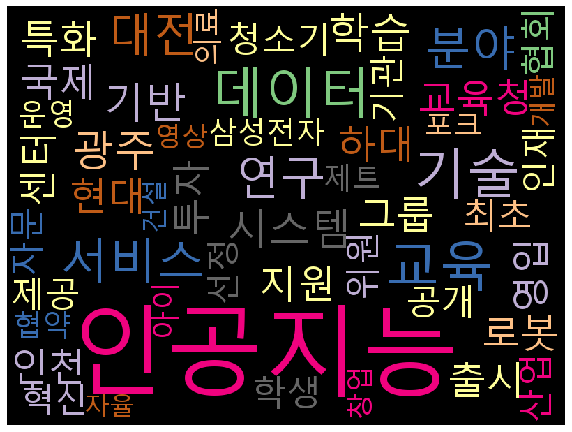

In [27]:
# wordcloud = WordCloud(font_path='C:/Windows/Fonts/malgun.ttf',
#                       background_color='white',                   
#                       colormap = 'Accent_r',   
#                       width=800,
#                       height=600)

wordcloud = WordCloud(font_path='C:/Windows/Fonts/malgun.ttf',
                      colormap = 'Accent_r',
                      width=800,
                      height=600)

print(dict(words))

cloud = wordcloud.generate_from_frequencies(dict(words))

plt.figure(figsize=(10, 8))

plt.axis('off')   

plt.imshow(cloud)

plt.show()
